#Configuração do Colab

Irregular object: https://stackoverflow.com/questions/64394768/how-calculate-the-area-of-irregular-object-in-an-image-opencv-python-3-8

Blob detection: https://www.youtube.com/watch?v=2puHfSKnG7c 

Mask R-CNN: https://www.youtube.com/watch?v=8m8m4oWsp8M

Color segmentation: https://www.youtube.com/watch?v=efWITgemKvs

#Importações

##Módulos e Bibliotecas

In [161]:
from datetime import datetime

import cv2 as cv
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
from pandas import DataFrame as df

import matplotlib.pyplot as plt

from skimage import measure, io, img_as_ubyte
from skimage.color import label2rgb, rgb2gray

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border

##Imagem

cv.imread: https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/

Image 1


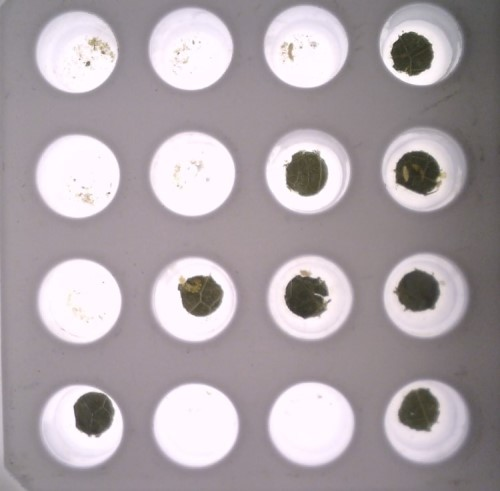

Image 0


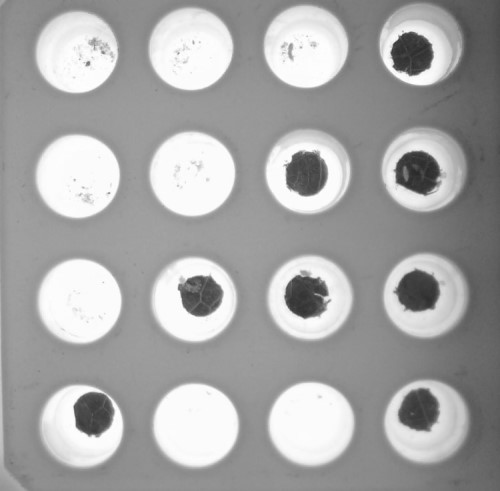

In [162]:
# file information
ImgFile = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/larvas_bandeja_2.jpg'

# read image
src1 = cv.imread(ImgFile,1)                             #Colorida
src0 = cv.imread(ImgFile,0)                             #grayscale

# show original image
print("Image 1")
cv2_imshow(src1)
print("Image 0")
cv2_imshow(src0)

#Função - Recortar Foto

##Aplicação dos filtros

Open.cv: https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html 

cv.dilate: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

cv.medianBlur: https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9

cv.absdiff: https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga6fef31bc8c4071cbc114a758a2b79c14 

cv.normalize: https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html#normalize

cv.merge: https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga7d7b4d6c6ee504b30a20b1680029c7b4

cv.threshold: https://docs.opencv.org/4.5.2/d7/d4d/tutorial_py_thresholding.html

Otsu's thresholding: https://learnopencv.com/otsu-thresholding-with-opencv/

In [ ]:
src1 = src1[200:900, 570:1320].copy()
#[200:900, 570:1320]
src0 = src0[200:900, 570:1320].copy()

Edges Filter


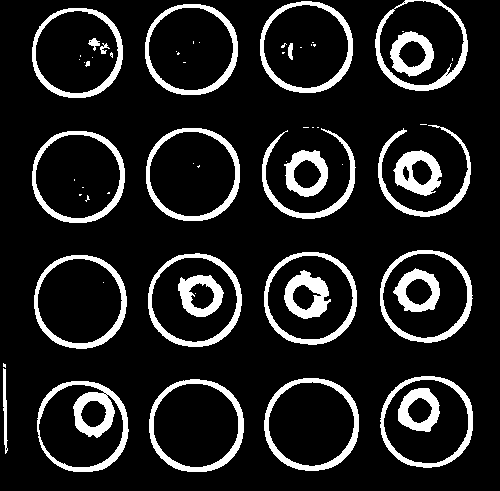

In [163]:
rgb_planes = cv.split(src0)

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv.dilate(plane, np.ones((10,10), np.uint8))
    bg_img = cv.medianBlur(dilated_img, 21)
    diff_img = 255 - cv.absdiff(plane, bg_img)
    norm_img = cv.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)

result = cv.merge(result_planes)
result_norm = cv.merge(result_norm_planes)

maxValue = 255
retval, dst = cv.threshold(result, 0, maxValue, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

# show image with edges
print("Edges Filter")
cv2_imshow(dst)

##Localizar os círculos

cv.HoughCircles: https://medium.com/turing-talks/houghcircles-detec%C3%A7%C3%A3o-de-c%C3%ADrculos-em-imagens-com-opencv-e-python-2d229ad9d43b 

In [164]:
# Achar os círculos
circles = cv.HoughCircles(dst,
                          cv.HOUGH_GRADIENT,
                          dp=1.3,
                          minDist=110,
                          param1=110,
                          param2=8,
                          minRadius=47,
                          maxRadius=52)
# 1.15, 110, 100, 8, 46, 50
# Mudar para inteiro
circles = np.uint16(np.around(circles))
print(circles)

[[[309 297  42]
  [424 295  42]
  [196 422  44]
  [193 298  42]
  [ 76 178  44]
  [ 79 298  44]
  [310 422  43]
  [425 172  44]
  [ 74  51  43]
  [ 85 427  44]
  [193  47  44]
  [307  43  44]
  [421  41  42]
  [427 422  42]
  [305 169  44]
  [189 173  44]]]


In [165]:
# Save circles coordinates in a list of tuples(center)
group='A'
center = []
for i in circles[0,:]:
    center.append([i[0],i[1], i[2]])
# treat circles with pandas dataframe 
df = pd.DataFrame(center, columns=['x','y','radius'])
# order circles by x position and limit result to 16 circles (this will exclude the other circles)
df = df.sort_values(by='x').reset_index(drop=True).head(n=16) 
# creates group_index
df['group_index'] = str(group)
# creates cell_index
df = df.sort_values(by=['group_index', 'y'])
df['cell_index'] = range(1, 17)


# show circles information
print(df)

      x    y  radius group_index  cell_index
12  421   41      42           A           1
9   307   43      44           A           2
6   193   47      44           A           3
0    74   51      43           A           4
8   305  169      44           A           5
14  425  172      44           A           6
4   189  173      44           A           7
1    76  178      44           A           8
13  424  295      42           A           9
10  309  297      42           A          10
2    79  298      44           A          11
5   193  298      42           A          12
7   196  422      44           A          13
11  310  422      43           A          14
15  427  422      42           A          15
3    85  427      44           A          16


Image With Circles


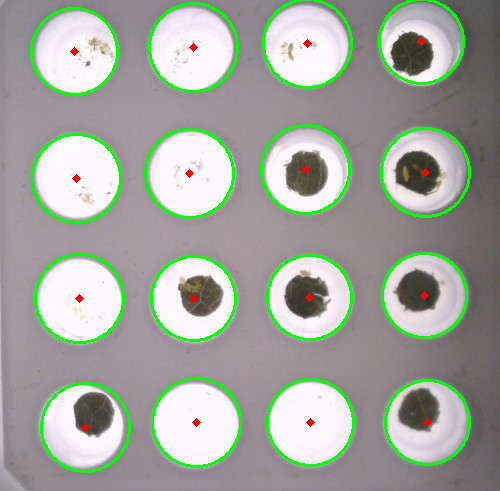

In [166]:
# desenhar os círculos na imagem
circles_image = src1.copy()
for index, row in df.iterrows():
    # desenhar a borda do círculo
    cv.circle(circles_image,(df.x[index],df.y[index]),
              df.radius[index],(0,255,0),2)
    # desenhar o centro do círculo
    cv.circle(circles_image,(df.x[index],df.y[index]),2,(0,0,255),3)
# exibir imagem com círculos
print("Image With Circles")
cv2_imshow(circles_image)

##Divisão da Imagem

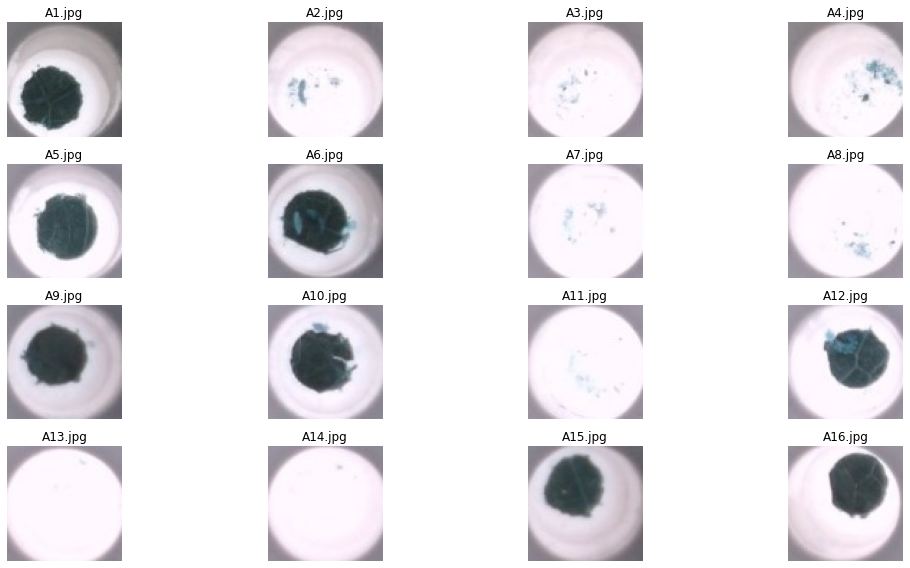

In [167]:
i = 0
fig, axes = plt.subplots(4, 4, figsize=(16, 8), sharex=True, sharey=True)
ax = axes.ravel()
for index, row in df.iterrows():
  # crop image
  image = src1[(df.y[index]-40):(df.y[index]+40),(df.x[index]-40):(df.x[index]+40)]
  # 100
  # save image
  image_name = str(df.group_index[index])+str(df.cell_index[index])+'.jpg'
  cv.imwrite('/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/'+image_name, image) 
  ax[i].imshow(image)
  ax[i].set_title(image_name)
  i+=1

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

#Análise da Figura - Algoritmo Caio

##Função - Análise da Área

In [ ]:
lagarta_lista = []
folha_lista = []
horario_atual = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
scale = 0.6
condicao = 'Controle'
operador = 'João'
planta = 'Soja'
lagarta = 'Chrysodeixis includens'

In [168]:
def main(cell):
  file_path = '/content/drive/MyDrive/Mauá/TCC/Códigos/Imagens/Imagens cortadas/'
  arquivo = file_path + cell + ".jpg"
  image = cv.imread(arquivo,1)
  image_gray = cv.imread(arquivo,0)

  # Threshold
  threshold = threshold_otsu(image_gray)
  thresholded_img = image < threshold
  
  # Labels
  label_image = measure.label(thresholded_img,
                              connectivity = image.ndim)

  all_props = measure.regionprops(label_image, image)
  #Can print various parameters for all objects
  for prop in all_props:
    # print('Label: {} Area: {}'.format(prop.label, prop.area))
    props = measure.regionprops_table(label_image, image, 
                          properties=['label',
                                      'area', 'equivalent_diameter'])
  
  scale = 0.6
  df2 = pd.DataFrame(props)
  # Converter em escala micron
  df2['equivalent_diameter_microns'] = df2['equivalent_diameter'] * (scale)
  df2['area_sq_microns'] = df2['area'] * (scale**2)

  del df2['equivalent_diameter']
  # del df2['area']
  # Filtrar áreas
  df2.drop(df2[df2.area < 200].index, inplace=True) # grãos
  df2.drop(df2['area_sq_microns'].idxmax(), inplace=True) # bandeja
  df2['Cell'] = cell
  total_area = df2['area_sq_microns'].sum()
  display(df2)
  return total_area

##Executa a Função

In [169]:
# read image
lista=[]
cells=[]

for i in range(1,17):
  leaf_index=group+str(i)
  area = main(leaf_index)
  lista.append(area)
  cells.append(leaf_index)

,label,area,equivalent_diameter_microns,area_sq_microns,Cell
0,1,2477,10.072263,891.72,A1
2,3,570,6.172247,205.20,A1
3,4,448,5.696101,161.28,A1


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
7,8,637,6.405183,229.32,A2
8,9,442,5.670558,159.12,A2


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
3,4,859,7.076461,309.24,A3
4,5,462,5.754828,166.32,A3


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
1,2,323,5.107628,116.28,A4
6,7,599,6.275196,215.64,A4


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
0,1,1883,9.192532,677.88,A5
2,3,650,6.448462,234.00,A5
3,4,313,5.054364,112.68,A5


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
0,1,357,5.280898,128.52,A6
1,2,672,6.520408,241.92,A6
4,5,1074,7.623478,386.64,A6
5,6,651,6.451767,234.36,A6


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
1,2,576,6.193829,207.36,A7
6,7,425,5.596906,153.00,A7


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
1,2,512,5.955365,184.32,A8
6,7,801,6.913467,288.36,A8


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
0,1,748,6.757493,269.28,A9
1,2,676,6.533320,243.36,A9
3,4,575,6.190242,207.00,A9
4,5,589,6.240080,212.04,A9


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
0,1,682,6.552593,245.52,A10
1,2,641,6.418562,230.76,A10
3,4,567,6.161400,204.12,A10
4,5,531,6.028138,191.16,A10


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
2,3,605,6.296079,217.80,A11
3,4,498,5.900582,179.28,A11


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
0,1,819,6.964870,294.84,A12
1,2,696,6.597126,250.56,A12
3,4,587,6.233009,211.32,A12
4,5,474,5.804228,170.64,A12


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
1,2,520,5.986222,187.20,A13
2,3,492,5.876789,177.12,A13


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
1,2,691,6.581290,248.76,A14
2,3,544,6.076936,195.84,A14


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
0,1,583,6.218819,209.88,A15
1,2,718,6.665916,258.48,A15
3,4,862,7.084689,310.32,A15
4,5,550,6.099196,198.00,A15


,label,area,equivalent_diameter_microns,area_sq_microns,Cell
0,1,378,5.382479,136.08,A16
1,2,2144,9.599014,771.84,A16
3,4,602,6.285655,216.72,A16


### CSV

In [170]:
#### Valores para edição #########
bioassay = 9895
path = '/Bayer/Resultados_Bioassay/'
operador = 'Bang'
planta = 'Soja'
lagarta = 'Chrysodeixis includens'
condicao = 'Controle'
hora_atual = datetime.now().strftime("%d/%m/%Y %H:%M:%S")


teste =[]
n= 0
for i in range(len(lista)):
  teste.append(lista[i]*(0.1+n))
  n += 0.05

In [171]:
def csv_inicial():
  df = pd.DataFrame()
  df = pd.DataFrame(folha_lista)
  df = df.rename(columns={'area':'area_folha'})
  df = df.apply(pd.Series.explode)
  # Filtrar áreas
  # df = df[(df.area_folha > 700) & (df.area_folha < 3000)] # grãos
  df = df.groupby("Célula_ID").sum().sort_values(by=['Célula_ID'])
  df = df.reset_index()
  # df.drop(columns='label', inplace=True)

  df2 = pd.DataFrame()
  df2 = pd.DataFrame(lagarta_lista)
  df2 = df2.apply(pd.Series.explode)
  df2 = df2.groupby("Célula_ID").sum().sort_values(by=['Célula_ID'])
  df2 = df2.reset_index()

  # Converter em escala micron
  df["A0_Folha"] = df['area_folha'] * (scale**2)
  df['A0_Lagarta'] = df2['area'] * (scale**2)

  df['Data início'] = horario_atual
  df['Data final'] = ''
  df['Grupo_ID'] = 'A'
  df['Condição'] = condicao
  df['Planta'] = planta
  df['Lagarta'] = lagarta
  df['Técnico'] = operador
  df["A'_Folha"] = ''
  df["A'_Lagarta"] = ''
  df['Redução (%)'] = ''
  df['Aumento (%)'] = ''
  df['Status da lagarta'] = ''
  df = df[['Data início', 'Data final', 'Técnico', 'Planta', 'Lagarta', 'Condição', 'Grupo_ID', 'Célula_ID',
          'A0_Folha', "A'_Lagarta", 'Redução (%)', 'A0_Lagarta', "A'_Lagarta", 'Aumento (%)', 'Status da lagarta']]

  # print(lagarta_lista)
  display(df)
csv_inicial()

,Data início,Data final,Operador,Planta,Lagarta,Condição,Groupo_ID,Cell_ID,Área inicial da planta,Área final da planta,Redução (%),Nível de redução
0,21/09/2021 21:12:11,,Bang,Soja,Chrysodeixis includens,Controle,A,1,1258.20,,,
1,21/09/2021 21:12:11,,Bang,Soja,Chrysodeixis includens,Controle,A,2,388.44,,,
2,21/09/2021 21:12:11,,Bang,Soja,Chrysodeixis includens,Controle,A,3,475.56,,,
3,21/09/2021 21:12:11,,Bang,Soja,Chrysodeixis includens,Controle,A,4,331.92,,,
4,21/09/2021 21:12:11,,Bang,Soja,Chrysodeixis includens,Controle,A,5,1024.56,,,
5,21/09/2021 21:12:11,,Bang,Soja,Chrysodeixis includens,Controle,A,6,991.44,,,
6,21/09/2021 21:12:11,,Bang,Soja,Chrysodeixis includens,Controle,A,7,360.36,,,
7,21/09/2021 21:12:11,,Bang,Soja,Chrysodeixis includens,Controle,A,8,472.68,,,
8,21/09/2021 21:12:11,,Bang,Soja,Chrysodeixis includens,Controle,A,9,931.68,,,
9,21/09/2021 21:12:11,,Bang,Soja,Chrysodeixis includens,Controle,A,10,871.56,,,


In [172]:
def csv_final():
  db_final = pd.read_csv('/content/drive/MyDrive/Mauá/TCC/Códigos/CSV/' + str(bioassay) + '.csv')

  db_final['Área final da planta'] = teste # teste depois apagar
  db_final['Redução (%)'] = round((db_final['Área inicial da planta'] - db_final['Área final da planta']) / db_final['Área inicial da planta'] *100, 2)
  db_final['Data final'] = hora_atual

  # lista de condições para nível de redução
  conditions1 = [
      (db_final['Redução (%)'] >= 90), (db_final['Redução (%)'] < 90) & (db_final['Redução (%)'] >= 80),
       (db_final['Redução (%)'] < 80) & (db_final['Redução (%)'] >= 70), (db_final['Redução (%)'] < 70) & (db_final['Redução (%)'] >= 60), 
       (db_final['Redução (%)'] < 60) & (db_final['Redução (%)'] >= 50), (db_final['Redução (%)'] < 50) & (db_final['Redução (%)'] >= 40), 
       (db_final['Redução (%)'] < 40) & (db_final['Redução (%)'] >= 30), (db_final['Redução (%)'] < 30) & (db_final['Redução (%)'] >= 20), 
       (db_final['Redução (%)'] < 20) & (db_final['Redução (%)'] >= 10), (db_final['Redução (%)'] < 10)
      ]
  # # lista de valores para cada condição
  values1 = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
  db_final['Nível de redução'] = np.select(conditions1, values1)
  db_final.drop(db_final.columns[0], axis=1, inplace=True)
  db_final.to_csv('/content/drive/MyDrive/Mauá/TCC/Códigos/CSV/' + str(bioassay) + '.csv')
  display(db_final) # teste depois tirar
csv_final()

,Data início,Data final,Operador,Planta,Lagarta,Condição,Groupo_ID,Cell_ID,Área inicial da planta,Área final da planta,Redução (%),Nível de redução
0,21/09/2021 21:12:11,21/09/2021 21:12:11,Bang,Soja,Chrysodeixis includens,Controle,A,1,1258.20,125.820,90.0,10
1,21/09/2021 21:12:11,21/09/2021 21:12:11,Bang,Soja,Chrysodeixis includens,Controle,A,2,388.44,58.266,85.0,9
2,21/09/2021 21:12:11,21/09/2021 21:12:11,Bang,Soja,Chrysodeixis includens,Controle,A,3,475.56,95.112,80.0,9
3,21/09/2021 21:12:11,21/09/2021 21:12:11,Bang,Soja,Chrysodeixis includens,Controle,A,4,331.92,82.980,75.0,8
4,21/09/2021 21:12:11,21/09/2021 21:12:11,Bang,Soja,Chrysodeixis includens,Controle,A,5,1024.56,307.368,70.0,8
5,21/09/2021 21:12:11,21/09/2021 21:12:11,Bang,Soja,Chrysodeixis includens,Controle,A,6,991.44,347.004,65.0,7
6,21/09/2021 21:12:11,21/09/2021 21:12:11,Bang,Soja,Chrysodeixis includens,Controle,A,7,360.36,144.144,60.0,7
7,21/09/2021 21:12:11,21/09/2021 21:12:11,Bang,Soja,Chrysodeixis includens,Controle,A,8,472.68,212.706,55.0,6
8,21/09/2021 21:12:11,21/09/2021 21:12:11,Bang,Soja,Chrysodeixis includens,Controle,A,9,931.68,465.840,50.0,6
9,21/09/2021 21:12:11,21/09/2021 21:12:11,Bang,Soja,Chrysodeixis includens,Controle,A,10,871.56,479.358,45.0,5


#Laços de Repetição

In [173]:
# #Define os grupos
# group_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# #Percorre os paths de fotos dos grupos
# for group in group_list:
#   group_path = path+str(bioassay)+'/Fotos_Originais/'+str(bioassay)+'_Grupo_'+group
#   print(group_path)

# #Linha de separação
# print()
# print("*"*100)
# print()

# #Percorre os paths de fotos das folhas cortadas
# for group in group_list:
#   for i in range(1,17):
#     img_path = path+str(bioassay)+'/Fotos_Cortadas/'+str(bioassay)+'_Foto_'+group+str(i)
# print(img_path)

#Realizar Teste

In [174]:
# def Capturar_Imagens():
#   pass

# def Cortar_Imagens(group_path):
#   pass
  
# def Analisar_Imagens(img_path):
#   return True

In [175]:
# #Valores para edição
# bioassay = 9895
# path = '/Bayer/Resultados_Bioassay/'

# #Define os grupos
# group_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

# #Execução da Função de Captura das Imagens
# Capturar_Imagens()

# #Execução da Função de Corte das Imagens
# for group in group_list:
#   group_path = path+str(bioassay)+'/Fotos_Originais/'+str(bioassay)+'_Grupo_'+group
#   Cortar_Imagens(group_path)

# #Execução da Função de Análise das Imagens
# ListGroup = []
# ListCell = []
# ListArea = []
# for group in group_list:
#   for i in range(1,17):
#     img_path = path+str(bioassay)+'/Fotos_Cortadas/'+str(bioassay)+'_Foto_'+group+str(i)
#     img_area = Analisar_Imagens(img_path)
#     ListArea.append(img_area)
#     ListCell.append(i)
#     ListGroup.append(group)

# df = pd.DataFrame()
# df['Group'] = ListGroup
# df['Cell'] = ListCell
# df['Área'] = ListArea

# display(df.set_index('Cell').T)